In [1]:
!nvidia-smi

Sat Oct  5 15:53:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
%pip install --upgrade chess -q
# %pip install --upgrade -q torch torcheval torchtnt torchmetrics
# # %pip install --upgrade -q torch #--index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


In [1]:
import gc
import random
import re
from collections import defaultdict
from glob import glob
from itertools import chain
from pprint import pprint
from typing import List

import numpy as np
import pandas as pd
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from IPython.display import Markdown, display
from torch.utils.data import DataLoader, Dataset
from torchtnt.utils.data.data_prefetcher import CudaDataPrefetcher
from tqdm.notebook import tqdm

# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.benchmark_limit = 0

tqdm.pandas()
import chess

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


def collect():
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_max_memory_allocated()
        torch.cuda.synchronize()

ModuleNotFoundError: No module named 'torchtnt'

In [ ]:
def vis(entries):
    display(entries["outcome"].value_counts())
    print("---" * 10)
    display(entries["is_capture"].value_counts())
    print("---" * 10)
    display(entries.groupby("game_id").size().describe())


def load_files(files):
    entries = pd.concat(
        [pd.read_parquet(f) for f in tqdm(files)], ignore_index=True
    ).drop_duplicates(["game_id", "board"])
    entries["outcome"] = entries["outcome"].fillna(0)
    return entries

In [ ]:
files = glob("chess-dataset/dataset-v3/*")
entries = pd.concat(
    [
        pd.read_parquet(f)
        for f in tqdm(files)
    ],
    ignore_index=True,
).drop_duplicates(["game_id", "move", "board"])
entries["outcome"] = entries["outcome"].fillna("/")
display(entries)
display(entries.groupby("outcome").size())
# files

In [ ]:
# games_results = entries.groupby("game_id").apply(
#     lambda x: len(x) <= 120 and x.iloc[-1]["outcome"]
# )
# bad_examples_idx = games_results[games_results != "CHECKMATE"].index.to_list()
# mask = entries["game_id"].isin(bad_examples_idx)
# bad_examples = entries.loc[mask].copy()
# entries = entries.loc[~mask].copy()

# Remove the game before the first capture
# entries = (
#     entries.groupby("game_id")
#     .apply(lambda x: x.loc[x["is_capture"].idxmax() - 1 :])
#     .reset_index(drop=True)
# )

# idxs = list(entries.groupby("game_id").groups.keys())
# idxs = pd.DataFrame(idxs).sample(frac=1, random_state=seed).values.ravel()
# entries[entries["game_id"].isin(idxs)]
gc.collect()

In [ ]:
entries["outcome"] = entries["outcome"].fillna("/")
vis(entries)

In [31]:
def mate_to_centipawn(mate_in_moves):
    sign = 1
    if mate_in_moves <= 0:
        sign = -1
    # return sign* (10000 - 2000 * math.log(abs(mate_in_moves)+1))
    return sign*10_000/(2**abs(mate_in_moves)+1)

In [32]:
import math
for i in range(-5,7):
    print(i,mate_to_centipawn(i))

-5 -303.030303030303
-4 -588.2352941176471
-3 -1111.111111111111
-2 -2000.0
-1 -3333.3333333333335
0 -5000.0
1 3333.3333333333335
2 2000.0
3 1111.111111111111
4 588.2352941176471
5 303.030303030303
6 153.84615384615384


# Dataset is too imbalanced, trying to filter-out unuseful examples ...

In [33]:
# # # Filtering only the games for which we don't have any meaningful outcome

# entries = entries.groupby("game_id").filter(
#     lambda x: x["outcome"].iloc[-1]
#     == "CHECKMATE"
#     # len(x) <= 200
#     # and len(x) > 51
#     # and x["outcome"].iloc[-1] != "SEVENTYFIVE_MOVES"
#     # and x["outcome"].iloc[-1] != "STALEMATE"
#     # and x["outcome"].iloc[-1] != "FIVEFOLD_REPETITION"
#     # and x["outcome"].iloc[-1] == "CHECKMATE"
# )
# vis(entries)

## Show a random game

In [34]:
# mask = entries["game_id"] == random.choice(entries["game_id"].unique())
# board = chess.Board()
# random_game = entries[mask]
# for fen in random_game["board"].values:
#     board.set_board_fen(fen.split()[0])
#     display(board)

In [35]:
def clean_score(score):
    # FIXME: Understand a real way to encode the score
    if score[1:].isdigit():
        score = int(score[1:])
    elif len(score) > 2 and score[2:].isdigit():
        score = (100 * 7) / int(score[2:])
    else:
        score = int(score)
    return abs(score)


# entries["score"] = entries["score"].progress_apply(lambda x: clean_score(x))
_mean = entries["score"].mean()
_std = entries["score"].std()
entries["score"] = (entries["score"] - _mean) / _std
# entries["score"] = entries["score"] / entries["score"].max()

In [36]:
# entries.sort_values(['game_id','#_turn'],inplace=True)
dummies = pd.get_dummies(entries, columns=["is_capture", "outcome"], dtype=int)
df_train = dummies.head(int(len(dummies) * 0.9))
df_test = dummies.tail(len(dummies) - len(df_train))
del dummies
gc.collect()
len(df_train), len(df_test)

(929265, 103252)

In [37]:
# FIXME: Understand a better way for get unique game batches.
def get_unique_games_from_batches(X, y):
    unique_games = {}
    unique_idx = []
    for i in tqdm(range(X.shape[0]), mininterval=1):
        x = "|".join([v[:-13] for v in X[i]]) + "|".join(y[i])
        if x not in unique_games:
            unique_games[x] = None
            unique_idx.append(i)
    return unique_idx


def create_timeseries_v3(y, window=6, **kwargs):
    X = defaultdict(list)
    _y = []
    for k in kwargs:
        for i in range(len(kwargs[k]) - (window - 1)):
            X[k].append(kwargs[k][i : i + window])

    for k in X:
        X[k] = np.stack(X[k])
    for i in range(len(y) - (window - 1)):
        _y.append(y[i : i + window])
    return X, np.asarray(_y)


def generate_dataset(df, window=6):
    X_train = defaultdict(list)
    y_train = []
    capture_cols = [c for c in df.columns if "is_capture" in c]
    outcome_cols = [c for c in df.columns if "outcome" in c]
    for l, game in tqdm(df.groupby("game_id"), mininterval=1):
        a, b = create_timeseries_v3(
            game["move"].values,
            window,
            **{
                # 'idxs':game['#_turn'].values,
                "boards": game["board"].values,
                "scores": game["score"].values,
                "is_capture": game[capture_cols].values,
                "outcomes": game[outcome_cols].values,
            },
        )
        for k in a:
            X_train[k].extend(a[k])
        y_train.extend(b)
    for k in X_train:
        X_train[k] = np.asarray(X_train[k])
    y_train = np.asarray(y_train)
    n = len(y_train)
    unique_idx = get_unique_games_from_batches(X_train["boards"], y_train)
    print(f"Removed {n - len(unique_idx)} duplicated entries")
    return {k: X_train[k][unique_idx] for k in X_train}, y_train[unique_idx]


X_train, y_train = generate_dataset(df_train.head(5000))

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/4695 [00:00<?, ?it/s]

Removed 1 duplicated entries


In [38]:
class FenParser:
    """ """

    def __init__(self):
        self.rank_re = re.compile(r"(\d|[kqbnrpKQBNRP])")
        self.piece_re = re.compile(r"([kqbnrpKQBNRP])")
        self.piece_to_index = {
            " ": 0,
            "P": 1,
            "N": 2,
            "B": 3,
            "R": 4,
            "Q": 5,
            "K": 6,
            "p": 7,  # White
            "n": 8,
            "b": 9,
            "r": 10,
            "q": 11,
            "k": 12,  # Black
        }
        self.piece_map = {
            " ": " ",
            "P": "PED",
            "N": "CAV",
            "B": "ALF",
            "R": "TOR",
            "Q": "REG",
            "K": "RE",
            "p": "ped",
            "n": "cav",
            "b": "alf",
            "r": "tor",
            "q": "reg",
            "k": "re",
        }
        self.index_to_piece = {v: k for k, v in self.piece_to_index.items()}

    def parse(self, fen_str):
        ranks = fen_str.split(" ")[0].split("/")
        pieces_on_all_ranks = [self.parse_rank(rank) for rank in ranks]
        return pieces_on_all_ranks

    def parse_rank(self, rank):
        piece_tokens = self.rank_re.findall(rank)
        pieces = self.flatten(map(self.expand_or_noop, piece_tokens))
        return pieces

    def flatten(self, lst):
        return list(chain(*lst))

    def expand_or_noop(self, piece_str):
        if self.piece_re.match(piece_str):
            return piece_str
        return self.expand(piece_str)

    def to_tensor(self, fen):
        tensor = torch.zeros((8, 8, 13), dtype=torch.int)

        # Split the FEN string by spaces to get the board part
        board_fen = fen.split()[0]

        # Process each rank (row) in the FEN board part
        rank_fen = board_fen.split("/")

        for rank_idx, rank in enumerate(rank_fen):
            file_idx = 0
            for char in rank:
                if char.isdigit():
                    # Empty squares (advance file index by the number)
                    file_idx += int(char)
                else:
                    # Fill the appropriate channel for the piece
                    piece_idx = self.piece_to_index[char]
                    tensor[rank_idx, file_idx, piece_idx] = 1
                    file_idx += 1

        return torch.IntTensor(tensor)

    def tensor_to_board_v2(self, t):
        t = torch.Tensor.tolist(t)
        for i in range(len(t)):
            for j in range(len(t[0])):
                t[i][j] = fp.index_to_piece.get(t[i][j])
                t[i][j] = fp.piece_map[t[i][j]]
        print(
            tabulate.tabulate(
                t,
                tablefmt="heavy_grid",
                headers=[chr(ord("A") + i) for i in range(8)],
                showindex=list(range(8, 0, -1)),
            )
        )

    def to_fen(self, tensor):
        fen = ""
        # Iterate over each rank (row)
        for rank_idx in range(8):
            empty_squares = 0
            for file_idx in range(8):
                # Find the active channel (piece) for this square
                piece_idx = np.argmax(tensor[rank_idx, file_idx])
                if piece_idx == 0:  # Empty square
                    empty_squares += 1
                else:
                    if empty_squares > 0:
                        fen += str(empty_squares)
                        empty_squares = 0
                    fen += self.index_to_piece[piece_idx]
            if empty_squares > 0:
                fen += str(empty_squares)
            fen += "/"

        # Remove the trailing slashs
        return fen[:-1]

    def expand(self, num_str):
        return int(num_str) * " "

    # FIXME: Use a 2d -> 2d index instead of a flatten 4096 array
    def uci_to_index(self, move):
        start_square = chess.parse_square(move[:2])
        end_square = chess.parse_square(move[2:4])
        return start_square * 64 + end_square

    def index_to_uci(self, index):
        start_square = index // 64
        end_square = index % 64
        uci_move = chess.square_name(start_square) + chess.square_name(end_square)
        return uci_move


fp = FenParser()
pprint(fp.parse(entries.iloc[0]["board"]))
pprint(fp.to_tensor(entries.iloc[0]["board"]))
t = fp.to_tensor(entries.iloc[0]["board"])
t.shape

[['r', 'n', 'b', 'q', 'k', 'b', 'n', 'r'],
 ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
 ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
 ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']]
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    

torch.Size([8, 8, 13])

In [2]:
class ChessDataset(Dataset):
    def __init__(
        self,
        # idxs: List[int],
        boards: List[List[str]],
        moves: List[str],
        scores: List[float],
        is_capture: List[int],
        outcomes: List[int],
    ):
        # self.idxs = idxs
        self.boards = boards
        self.moves = moves
        self.scores = scores
        self.is_capture = is_capture
        self.outcomes = outcomes
        self.fen_parser = FenParser()

    def __len__(self):
        return len(self.boards)

    def __getitem__(self, idx):
        d = {
            # "idx": self.idxs[idx],
            "board": self.boards[idx],
            "move": self.moves[idx],
            "score": self.scores[idx],
            "is_capture": self.is_capture[idx],
            "outcome": self.outcomes[idx],
        }
        return d

    # FIXME: This is slow + CPU Bottleneck
    def collate_fn(self, d):
        boards = []
        moves = []
        colors = []
        scores = []
        is_capture = []
        outcome = []
        # idxs = []
        fens = []
        for entry in d:
            fens.append([fen for fen in entry["board"]])
            _boards = torch.stack(
                [
                    torch.argmax(self.fen_parser.to_tensor(fen), axis=-1).type(
                        torch.long
                    )
                    for fen in entry["board"]
                ]
            )
            boards.append(_boards)

            _moves = [
                self.fen_parser.uci_to_index(best_move) for best_move in entry["move"]
            ]
            _moves = torch.stack(
                [
                    # FIXME: Use 2d 8x8 -> 8x8 coordinates 
                    torch.nn.functional.one_hot(
                        torch.tensor(index).clone().detach(), num_classes=4095
                    ).type(dtype=torch.float32)
                    for index in _moves
                ]
            )
            moves.append(_moves)
            # idxs.append([idxs for idxs in entry["idx"]])
            scores.append([score for score in entry["score"]])
            is_capture.append([is_capture for is_capture in entry["is_capture"]])
            outcome.append([outcome for outcome in entry["outcome"]])
            colors.append([0 if _fen.split()[1] == "w" else 1 for _fen in fens[-1]])

        out = {
            # "idx": np.asarray(idxs),
            "fen": np.asarray(fens),
            "board_tensor": torch.stack(boards).type(torch.long),
            "move_index": torch.stack(moves),
            "scores": torch.FloatTensor(scores),
            "active_color": torch.IntTensor(colors),
            "is_capture": torch.FloatTensor(np.asarray(is_capture)),
            # FIXME: BUG! Outcome should contains at least:{0: WIN_WHITE, 1: WIN_BLACK 2: DRAW}
            #   In this way we are not able to "understand" the goal of the game
            "outcome": torch.FloatTensor(np.asarray(outcome)),
        }
        return out


device = torch.device("cuda")

collect()
window = 5
X_train, y_train = generate_dataset(df_train, window=window)
ds_train = ChessDataset(moves=y_train, **X_train)
del X_train, y_train, df_train
X_test, y_test = generate_dataset(df_test, window=window)
ds_test = ChessDataset(moves=y_test, **X_test)
del X_test, y_test
gc.collect()
batch_size = 4
_batch_size = 128
# Avoid to load to GPU. Prefetched during training only
dl_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ds_train.collate_fn,
)
dl_test = DataLoader(
    ds_test,
    batch_size=_batch_size,
    shuffle=True,
    collate_fn=ds_test.collate_fn,
)

for x1 in ds_train:
    for k in x1.keys():
        print(f"{k}->{x1[k].shape} | {x1[k].dtype}")
    break
for x2 in dl_train:
    for k in x2.keys():
        print(f"{k}->{x2[k].shape} | {x2[k].dtype}")
    break

x1.keys(), x2.keys()

NameError: name 'collect' is not defined

In [40]:
fp.tensor_to_board_v2(x2["board_tensor"][0, 0])

┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃ cav ┃ alf ┃ reg ┃     ┃ tor ┃ re  ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃     ┃     ┃     ┃     ┃ ped ┃ ped ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃ ped ┃     ┃     ┃     ┃     ┃ cav ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃ ped ┃     ┃ ped ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃ CAV ┃     ┃ PED ┃ ped ┃     ┃     ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃     ┃     ┃ PED ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃ PED ┃ PED ┃     ┃     ┃ ALF ┃ PED ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃ TOR ┃     ┃ ALF ┃ REG ┃ RE  ┃     ┃     ┃ TOR ┃
┗━━━━┻━━━━

In [18]:
dropout = 0.5


class ChessNet(nn.Module):

    @staticmethod
    def build_emb(in_dim=13, out_dim=64) -> nn.Sequential:
        return nn.Sequential(
            nn.Embedding(in_dim, out_dim),
            # nn.Linear(out_dim, out_dim),
            # nn.ReLU(),
        )

    @staticmethod
    def buil_conv(
        in_dim=128,
        out_dim=256,
        k=(window, 2, 2),
        padding="same",
        pool: nn.Module = nn.MaxPool3d((1, 2, 2)),
        activation: nn.Module = nn.Mish,
    ) -> nn.Sequential:
        x = nn.Sequential(
            nn.BatchNorm3d(in_dim),
            nn.Conv3d(
                in_channels=in_dim, out_channels=out_dim, kernel_size=k, padding=padding
            ),
            activation(),
        )
        if pool is not None:
            x.add_module("pool", pool)
        return x

    def __init__(self):
        super(ChessNet, self).__init__()
        self.emb_piece = ChessNet.build_emb()
        self.emb_color = ChessNet.build_emb()
        self.conv1 = ChessNet.buil_conv()
        self.conv2 = ChessNet.buil_conv(k=(window, 3, 3))
        self.conv3 = ChessNet.buil_conv(k=(window, 5, 5))
        self.conv4 = nn.Sequential(
            ChessNet.buil_conv(768, 1024, k=(window, 1, 1), pool=None),
            ChessNet.buil_conv(1024, 2048, k=(window, 1, 1), pool=None),
            nn.BatchNorm3d(2048),
        )

        self.fc_features = nn.Sequential(
            nn.Linear(8192, 2048), nn.ReLU(), nn.Dropout(dropout)
        )
        self.fc_position = nn.Sequential(
            nn.Linear(8192, 4095),
        )
        self.fc_score = nn.Sequential(nn.Linear(2048, 1))
        self.fc_capture = nn.Sequential(nn.Linear(2048, x2["is_capture"].shape[-1]))
        self.fc_outcome = nn.Sequential(nn.Linear(2048, x2["outcome"].shape[-1]))

    def forward(
        self, board_tensor, scores, active_color, is_capture, outcome, **kwargs
    ):
        emb_board = self.emb_piece(board_tensor)
        # print("BOARD EMB", emb_board.shape)
        emb_color = self.emb_color(active_color)
        # print("COLOR EMB", emb_color.shape)
        emb_color = emb_color.unsqueeze(dim=2).unsqueeze(dim=3).expand(-1, -1, 8, 8, -1)
        # print("COLOR EXPAND", emb_color.shape)

        emb_board = torch.concat((emb_board, emb_color), axis=-1)
        # print("BOARD CONCAT", emb_board.shape)
        # [N, D, H, W, C]) --> N, C, D, H, W
        emb_board = emb_board.permute(0, 4, 1, 2, 3)
        # print("BOARD AFTER PERMUTE", emb_board.shape)

        cnn1 = self.conv1(emb_board)
        # print("conv1", cnn1.shape)
        cnn2 = self.conv2(emb_board)
        # print("conv2", cnn2.shape)
        cnn3 = self.conv3(emb_board)
        # print("conv3", cnn3.shape)

        cnn = torch.concat((cnn1, cnn2, cnn3), axis=1)
        # print("conv1", cnn.shape)
        cnn = nn.MaxPool3d((1, 3, 3), padding=(0, 1, 1))(cnn)
        cnn = self.conv4(cnn)

        cnn = cnn.permute(0, 2, 1, 3, 4)
        # print(cnn.shape)
        cnn = cnn.reshape(cnn.size(0), cnn.size(1), -1)
        features = self.fc_features(cnn)
        # print(features.shape)
        x1 = self.fc_position(cnn)
        x2 = np.squeeze(self.fc_score(features))
        x3 = self.fc_capture(features)
        x4 = self.fc_outcome(features)

        return {
            "position": x1,
            "score": x2,
            "capture": x3,
            "outcome": x4,
        }


collect()
model = ChessNet()  # .to(device)
# model = torch.load("models/chess-model-bigdata-v1-b256-epoch3-l_0.0001.pt", weights_only=False)
# model = torch.compile(model, mode="reduce-overhead")
# display(model)
output = model(**x2)
for k in output.keys():
    print(f"{k}->{output[k].shape} | {output[k].dtype}")

/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


position->torch.Size([4, 5, 4095]) | torch.float32
score->torch.Size([4, 5]) | torch.float32
capture->torch.Size([4, 5, 2]) | torch.float32
outcome->torch.Size([4, 5, 5]) | torch.float32


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:603: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv3d(


In [19]:
# del dl_train,dl_test, optimizer, loss_ce, loss, loss_mse, model
# collect()

In [ ]:
loss_ce = nn.CrossEntropyLoss()
loss_mse = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# FIXME: Understand a correct loss calculation mechanism.
pos_weight = 3.0  # Maximize position accuracy, especially for the first frame
capture_weight = 2.0  # Capture is important but secondary to position
outcome_weight = 1.0  # Outcome is important, especially for the final move
score_weight = 0.5  # Score is less important than others


def train_step(model, inputs):
    res = model(**inputs)
    position = res["position"].float()
    score = torch.squeeze(res["score"]).float()
    capture = res["capture"].float()
    outcome = res["outcome"].float()

    loss = torch.tensor(0, device=device, dtype=torch.float)
    # loss += loss_mse(score, inputs["scores"]) * score_weight
    for i in range(position.shape[1]):
        # Weight the loss ascending by the frame. We want to 'enforce' the network to at least understand whats happening
        loss += (
            (position.shape[1] - i)
            * loss_ce(
                torch.squeeze(position[:, i, :]),
                torch.squeeze(inputs["move_index"][:, i, :]),
            )
            * pos_weight
        )
        loss += (
            (position.shape[1] - i)
            * loss_ce(capture[:, i, :], inputs["is_capture"][:, i, :])
            * capture_weight
        )
        loss += (
            (position.shape[1] - i)
            * loss_ce(outcome[:, i, :], inputs["outcome"][:, i, :])
            * outcome_weight
        )
        loss += (
            (position.shape[1] - i)
            * loss_mse(score[:, i], inputs["scores"][:, i])
            * score_weight
        )

    return loss


collect()
batch_size = 64
dl_train = DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    prefetch_factor=4,
    persistent_workers=True,
    pin_memory=device.type == "cuda",
    drop_last=True,
    collate_fn=ds_train.collate_fn,
)

if device.type == "cuda":
    dl_train = CudaDataPrefetcher(dl_train, device, 32)
    dl_test = CudaDataPrefetcher(dl_test, device, 32)

model.to(device)
model.train()
with torch.enable_grad():
    for epoch in tqdm(range(15)):
        with tqdm(
            enumerate(CudaDataPrefetcher(dl_train, device, 32)),
            total=(len(ds_train.boards) + batch_size) // batch_size,
            leave=False,
            position=1,
        ) as pbar:

            avg_loss = 0
            loss = 0.0
            for idx, batch in pbar:
                optimizer.zero_grad()
                _loss = train_step(model, batch)
                _loss.backward()
                optimizer.step()

                loss += _loss.item()
                if idx % 50 == 0:
                    # d = {k: f"{v.detach().cpu().item():.2f}" for k, v in loss.items()}
                    pbar.set_description(f"AVG: {loss/(idx+1)} |  {_loss.item()}")
                pbar.update(1)
            print(f"AVG {loss/idx}")
            model_name = f"models/bigone/chess-model-v1-b{batch_size}-epoch-{epoch}-l_0.0001"
            torch.save(model, f"{model_name}.pt")
            torch.save(model.state_dict(), f"{model_name}_weight.pt")

/opt/conda/lib/python3.10/site-packages/torch/cuda/memory.py:343: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13587 [00:00<?, ?it/s]

AVG 10.65920125212264


  0%|          | 0/13587 [00:00<?, ?it/s]

AVG 9.748263767461458


  0%|          | 0/13587 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_name = f"models/bigone/chess-model-v2-b{batch_size}-epoch-{epoch}-l_0.0001"
torch.save(model, f"{model_name}.pt")
torch.save(model.state_dict(), f"{model_name}_weight.pt")

In [45]:
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4095).to(device)

accuracy.reset()
model.eval()
with torch.no_grad():
    for x3 in tqdm(
        CudaDataPrefetcher(dl_test, device, 32),
        total=len(df_test) // _batch_size,
        leave=False,
        position=1,
    ):
        res = model(**x3)
        position = res["position"]
        for i in range(position.shape[1]):
            accuracy.update(
                torch.argmax(position[:, i], axis=-1),
                torch.argmax(x3["move_index"][:, i], axis=-1),
            )

print(accuracy.compute())

  0%|          | 0/806 [00:00<?, ?it/s]

tensor(0.8354, device='cuda:0')


## Filter only the games for which we have a different prediction 

In [47]:
max_example = 10
model.eval()
n = 0
with torch.no_grad():
    for x3 in tqdm(
        CudaDataPrefetcher(dl_test, device, 32),
        total=len(df_test) // _batch_size,
        leave=False,
        position=1,
    ):
        best_moves = torch.argmax(x3["move_index"], axis=-1)
        res = model(**x3)
        preds = torch.argmax(res["position"], axis=-1)

        # Print only n-window moves for which at least 1 is different (-> avoid to print correct prediction)
        mask = torch.any(best_moves != preds, axis=1)
        preds = preds[mask][:max_example]
        best_moves = best_moves[mask][:max_example]
        n += mask.sum()
        for idx in range(preds.shape[0]):  # Batch size
            display(Markdown(f"#### Game START"))
            for move in range(preds.shape[1]):  # Frames
                board = x3["board_tensor"][idx, move]
                best_move = torch.argmax(x3["move_index"][idx, move]).item()

                print(
                    f"Best Move: {fp.index_to_uci(best_move)} | Predicted: {fp.index_to_uci(preds[idx, move].item())}"
                )
                fp.tensor_to_board_v2(board)
            display(Markdown(f"---------"))
        if n >= max_example:
            break

  0%|          | 0/806 [00:00<?, ?it/s]

#### Game START

Best Move: c5e6 | Predicted: c5e6
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃     ┃     ┃     ┃ re  ┃     ┃     ┃ tor ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃ alf ┃ alf ┃ ped ┃     ┃ ped ┃ ped ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃ ped ┃ ped ┃     ┃     ┃ reg ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃     ┃ cav ┃     ┃ ped ┃ CAV ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃ ped ┃     ┃ PED ┃     ┃ PED ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃ PED ┃ cav ┃     ┃ PED ┃ ALF ┃ CAV ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃ PED ┃     ┃     ┃     ┃ PED ┃ ALF ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃ TOR ┃     ┃ REG ┃ 

---------

#### Game START

Best Move: f2f3 | Predicted: f2f3
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃     ┃     ┃     ┃ re  ┃     ┃     ┃ tor ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃ ped ┃     ┃ cav ┃ reg ┃ ped ┃ alf ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃ ped ┃     ┃ ped ┃     ┃     ┃     ┃ ped ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃     ┃     ┃ ped ┃     ┃ ped ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃     ┃     ┃ PED ┃ cav ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃ PED ┃     ┃     ┃ CAV ┃ PED ┃     ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃ PED ┃ PED ┃     ┃ CAV ┃ PED ┃ PED ┃ ALF ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃ TOR ┃     ┃     ┃ REG ┃ 

---------

#### Game START

Best Move: c6c2 | Predicted: c6c2
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃     ┃ ped ┃     ┃     ┃     ┃ ped ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃ re  ┃ tor ┃     ┃     ┃     ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃ ped ┃     ┃ alf ┃ ped ┃     ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃ ped ┃ PED ┃     ┃ cav ┃ CAV ┃ tor ┃ ALF ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃ PED ┃     ┃     ┃ PED ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃     ┃     ┃ RE  ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃     ┃     ┃     ┃ 

---------

#### Game START

Best Move: c3h8 | Predicted: c3h8
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃     ┃     ┃ tor ┃     ┃     ┃ re  ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃     ┃     ┃     ┃     ┃ ped ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃     ┃     ┃     ┃     ┃     ┃ ped ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃ ped ┃     ┃ PED ┃     ┃ ped ┃     ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃ alf ┃     ┃ CAV ┃     ┃ PED ┃     ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃ ped ┃ alf ┃ REG ┃     ┃     ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃     ┃     ┃     ┃     ┃ PED ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃ ALF ┃     ┃     ┃ 

---------

#### Game START

Best Move: a6a8 | Predicted: a6a8
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃     ┃     ┃ alf ┃     ┃ re  ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃     ┃ ped ┃     ┃     ┃ ped ┃ ped ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃ tor ┃     ┃     ┃     ┃     ┃     ┃ cav ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃ ped ┃     ┃     ┃     ┃ PED ┃     ┃ PED ┃ tor ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃ PED ┃     ┃     ┃     ┃     ┃     ┃     ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃ PED ┃     ┃     ┃ PED ┃ CAV ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃     ┃ PED ┃ TOR ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃     ┃     ┃ TOR ┃ 

---------

#### Game START

Best Move: g3f4 | Predicted: g3f4
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃     ┃     ┃     ┃     ┃ re  ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃ ped ┃     ┃     ┃     ┃     ┃     ┃     ┃ tor ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃     ┃     ┃ ped ┃     ┃ ped ┃     ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃ ped ┃     ┃     ┃ cav ┃ PED ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃ PED ┃     ┃ ped ┃     ┃ ped ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃ PED ┃     ┃     ┃     ┃     ┃ RE  ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃ TOR ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃ TOR ┃     ┃     ┃     ┃ 

---------

#### Game START

Best Move: f1d3 | Predicted: c4e3
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ tor ┃ cav ┃ alf ┃ reg ┃ re  ┃     ┃ cav ┃ tor ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃ ped ┃ ped ┃     ┃     ┃     ┃ ped ┃ ped ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃     ┃     ┃     ┃ ped ┃     ┃     ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃     ┃     ┃ ped ┃ PED ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃ alf ┃     ┃ PED ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃     ┃ CAV ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃ PED ┃ PED ┃     ┃     ┃     ┃ PED ┃ PED ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃ TOR ┃     ┃ ALF ┃ REG ┃ 

---------

#### Game START

Best Move: c4e3 | Predicted: f6f5
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃ TOR ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃     ┃     ┃     ┃     ┃     ┃ re  ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃ ped ┃     ┃     ┃     ┃ ped ┃ PED ┃     ┃ RE  ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃     ┃ cav ┃ tor ┃     ┃     ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃     ┃     ┃     ┃     ┃     ┃ CAV ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃     ┃     ┃     ┃ 

---------

#### Game START

Best Move: f6f5 | Predicted: d7d5
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃ ALF ┃     ┃ TOR ┃     ┃     ┃     ┃ ped ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃ ped ┃     ┃     ┃     ┃     ┃ ped ┃ re  ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃ ped ┃     ┃     ┃ ped ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃     ┃     ┃     ┃ ALF ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃     ┃     ┃     ┃     ┃     ┃     ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃ alf ┃ tor ┃     ┃     ┃     ┃ PED ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃     ┃     ┃     ┃ 

---------

#### Game START

Best Move: e1b1 | Predicted: c6b4
┏━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┳━━━━━┓
┃    ┃ A   ┃ B   ┃ C   ┃ D   ┃ E   ┃ F   ┃ G   ┃ H   ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  8 ┃     ┃ alf ┃ tor ┃     ┃ tor ┃     ┃ re  ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  7 ┃ ped ┃ ped ┃     ┃ reg ┃ cav ┃ ped ┃ ped ┃ ped ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  6 ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  5 ┃     ┃     ┃ ped ┃ ALF ┃ ped ┃ alf ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  4 ┃     ┃     ┃ PED ┃     ┃ CAV ┃     ┃     ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  3 ┃ PED ┃     ┃ ALF ┃ PED ┃ PED ┃     ┃ PED ┃     ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  2 ┃     ┃     ┃ REG ┃     ┃     ┃ PED ┃     ┃ PED ┃
┣━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━╋━━━━━┫
┃  1 ┃     ┃     ┃     ┃     ┃ 

---------

# Fight with stockfish

In [48]:
import gc
import random

import chess.engine
import pandas as pd
from tqdm.notebook import tqdm

import chess
STOCKFISH_PATH = "./stockfish/stockfish-ubuntu-x86-64-avx2"

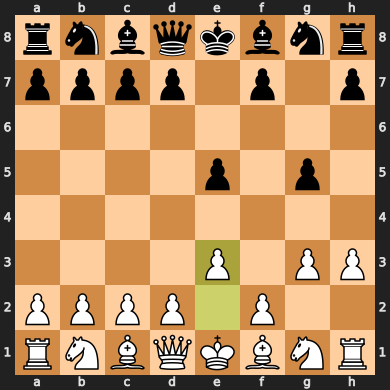

In [58]:
def push_move(board, move):
    board.push(move)
    hist.append(board.fen())
    color.append(len(board.move_stack) % 2)
    # if len(hist) > 3:
    #     hist.pop(0)
    #     color.pop(0)
    return


WHITE = 0
BLACK = 1
_ = {WHITE: "WHITE", BLACK: "BLACK"}
_map = {WHITE: [0, 1], BLACK: [1, 0]}


def generate_moves(hist, color, model=model):
    # The network is encoded in {0: White, 1: Black}
    _c = [int(c) for c in color[-window:]]
    _colors = [_map[c] for c in _c]
    v1 = torch.stack([fp.to_tensor(v) for v in hist[-window:]])
    v1 = torch.argmax(torch.unsqueeze(v1, 0), axis=-1)
    _in = {
        "board_tensor": v1.int().to(device),
        "active_color": torch.ones(1, window).int().to(device),
        "is_capture": torch.zeros(1, window, 2),
        "outcome": torch.zeros(1, window, 2),
        "scores": torch.zeros(1, window),
    }

    res = model(inference=True, **_in)

    return (
        torch.squeeze(torch.argmax(res["position"], axis=-1)).detach().cpu()[-1].item()
    )


engine = chess.engine.SimpleEngine.popen_uci(STOCKFISH_PATH)
hist = []
color = []


def init_game():
    model.eval()
    board = chess.Board()
    move = random.choice(list(board.legal_moves))
    push_move(board, move)
    for i in range(window - 1):
        move = random.choice(list(board.legal_moves))
        push_move(board, move)
    mov_pred = generate_moves(hist, color)
    display(board)
    return board, hist, color, mov_pred


board, hist, color, mov_pred = init_game()

In [ ]:
idx = 0
limit = chess.engine.Limit(depth=1)
opponent = chess.engine.Opponent(is_engine=False, name="bot-v1", title="", rating=1000)
while not board.is_game_over():
    if len(board.move_stack) % 2 == BLACK:
        move = generate_moves(hist, color)
        move = fp.index_to_uci(move)
        move = chess.Move.from_uci(move)
        print(f"Model: {_[len(board.move_stack) % 2]} move {move}", end="")
        if not board.is_legal(move):
            move = random.choice(list(board.legal_moves))
            print(" | Non legal move! Doing random move:", move)

    else:
        result = engine.play(
            board, limit, info=chess.engine.INFO_SCORE, opponent=opponent
        )
        move = result.move

    push_move(board, move)

    display(board)
    idx += 1
if board.is_game_over():
    print(board.result())
    print("Game over!")
    len(board.move_stack)
    display(board)

# Random Game

In [ ]:
idx = 0
board, hist, color, mov_pred = init_game()
while not board.is_game_over():
    if len(board.move_stack) % 2 == BLACK:
        move = generate_moves(hist, color)
        move = fp.index_to_uci(move)
        move = chess.Move.from_uci(move)
        print(f"Model: {_[len(board.move_stack) % 2]} move {move}", end="")
        if not board.is_legal(move):
            move = random.choice(list(board.legal_moves))
            print(" | Non legal move! Doing random move:", move)
    else:
        move = random.choice(list(board.legal_moves))

    push_move(board, move)

    display(board)
    idx += 1
if board.is_game_over():
    print(board.result())
    print("Game over!")
    display(board)

In [52]:
board.fullmove_number

72